UAE PERMAMANENT MISSION STATEMENTS SCRAPER

https://uaeun.org/?combined-search-post-types=statement&s=

In [1]:
import requests
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pandas as pd

STEP 1 - SCRAPE THE URLS AND NEWS ARTICLE CONTENTS SINCE 2022

In [6]:
# --- Config ---
base_url = "https://uaeun.org/"
params = {
    "combined-search-post-types": "statement",
    "s": "",
    "paged": 1
}
cutoff_date = datetime(2022, 1, 1)

In [7]:
def extract_links_and_dates(html):
    soup = BeautifulSoup(html, "html.parser")
    articles = []
    stop_scraping = False

    for item in soup.select("div.single-item"):
        time_tag = item.find("time")
        link_tag = item.select_one("a[href^='https://uaeun.org/statement/']")
        title_tag = item.find("strong", class_="title")

        if not time_tag or not link_tag or not title_tag:
            continue
        try:
            date = datetime.strptime(time_tag.text.strip(), "%b %d %Y")
            if date < cutoff_date:
                stop_scraping = True
                break
            title = title_tag.get_text(strip=True)
            url = link_tag['href']
            articles.append((title, url, date))
        except Exception:
            continue
    return articles, stop_scraping

def extract_article_text(url):
    try:
        headers = {
            "User-Agent": ("Mozilla/5.0 (Windows NT 10.0; Win64; x64) "
                           "AppleWebKit/537.36 (KHTML, like Gecko) "
                           "Chrome/114.0.0.0 Safari/537.36")
        }
        res = requests.get(url, headers=headers)
        res.raise_for_status()
        soup = BeautifulSoup(res.text, "html.parser")

        containers = soup.find_all("div", class_="container")
        for container in containers:
            paragraphs = container.find_all("p")
            if paragraphs:
                return "\n\n".join(p.get_text(strip=True) for p in paragraphs if p.get_text(strip=True))

        print(f"⚠️ No paragraph content found at {url}")
        return ""

    except Exception as e:
        print(f"⚠️ Error scraping {url}: {e}")
        return ""

In [8]:
# --- Scraping Loop ---
data = []
page = 1

while True:
    print(f"📄 Fetching page {page}")
    params["paged"] = page
    resp = requests.get(base_url, params=params)
    if resp.status_code != 200:
        print(f"❌ Failed to fetch page {page}")
        break

    entries, stop = extract_links_and_dates(resp.text)
    if not entries:
        print("ℹ️ No more articles found.")
        break

    for title, url, date in entries:
        print(f"🔗 Scraping: {title} ({date.strftime('%Y-%m-%d')})")
        content = extract_article_text(url)
        data.append({
            "title": title,
            "url": url,
            "date": date.strftime("%Y-%m-%d"),
            "content": content
        })
        time.sleep(0.5)

    if stop:
        print("🛑 Reached article older than cutoff date. Stopping.")
        break

    page += 1

# --- Save to DataFrame ---
df = pd.DataFrame(data)
print("\n✅ Scraped DataFrame preview:")
print(df.head())

# --- Save to Excel ---
excel_path = "uae_mission_statements.xlsx"
sheet_name = 'raw'

df.to_excel(excel_path, sheet_name=sheet_name, index=False)
print(f"📄 Articles saved to {excel_path}")

📄 Fetching page 1
🔗 Scraping: UAE Statement At the UN Security Council Briefing on Sudan (2025-06-27)
🔗 Scraping: UAE Statement at the UN Security Council Open Debate on Children and Armed Conflict (2025-06-25)
🔗 Scraping: UAE Statement At the Security Council Open Debate on Poverty, underdevelopment and conflict: Implications for international peace and security (2025-06-20)
🔗 Scraping: UAE Intervention at the Event to commemorate the 11th official observance of the International Day for the Elimination of Sexual Violence in Conflictco – Breaking the Cycle, Healing the Scars: Addressing the Intergenerational Effects of Conflict-Related Sexual Violence-CRSV (2025-06-19)
🔗 Scraping: UAE Statement at the Opening Segment of the Annual Session of the UN Women Executive Board (2025-06-18)
🔗 Scraping: UAE Statement At the Resumed Tenth Emergency Session of the General Assembly (2025-06-17)
🔗 Scraping: UAE Intervention At the High-Level Event to Commemorate the International Day for Counterin

STEP 2 - DATA ANALYSIS

In [7]:
excel_path = "uae_mission_statements.xlsx"
sheet_name = 'raw'

df = pd.read_excel(excel_path, sheet_name=sheet_name)

In [51]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction import _stop_words
from gensim import corpora
from gensim.models import Phrases, LdaModel
from gensim.models.phrases import Phraser
from wordcloud import WordCloud
import numpy as np
import matplotlib.pyplot as plt
import re

# Custom stopwords
custom_stopwords = set([
    'international', 'council', 'secuirty', 'efforts', 'president', 'mr',
    'political', 'region', 'people', 'support', 'uae', 'including',
    'united', 'arab', 'emirates', 'today', 'continue', 'un',
    'important', 'work', 'situation', 'global', 'world', 'regional',
    'community', 'need', 'parties', 'country', 'ensure', 'dprk',
    'united', 'nations', 'security', 'council', 'statement', 'continued',
    'context', 'regard', 'dialogue', 'resolution', 'especially', 'address',
    'welcome', 'humanitarian'
])

texts = df['content'].dropna().tolist()

# Combine the default English stopwords with custom list:
english_stopwords = _stop_words.ENGLISH_STOP_WORDS  # set of default english stopwords
all_stopwords = list(english_stopwords.union(custom_stopwords))

vectorizer = CountVectorizer(
    max_df=0.85, 
    min_df=5, 
    stop_words=all_stopwords
)

In [52]:
# Topic Identification without bigrams
dtm = vectorizer.fit_transform(texts)

lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(dtm)

# Function to print topics
def print_topics(model, feature_names, n_top_words):
    for idx, topic in enumerate(model.components_):
        print(f"Topic {idx}:")
        print([feature_names[i] for i in topic.argsort()[:-n_top_words - 1:-1]])

print_topics(lda, vectorizer.get_feature_names_out(),3)

Topic 0:
['sudan', 'peace', 'stability']
Topic 1:
['women', 'peace', 'climate']
Topic 2:
['syrian', 'syria', 'climate']
Topic 3:
['weapons', 'states', 'terrorism']
Topic 4:
['conflict', 'war', 'ukraine']


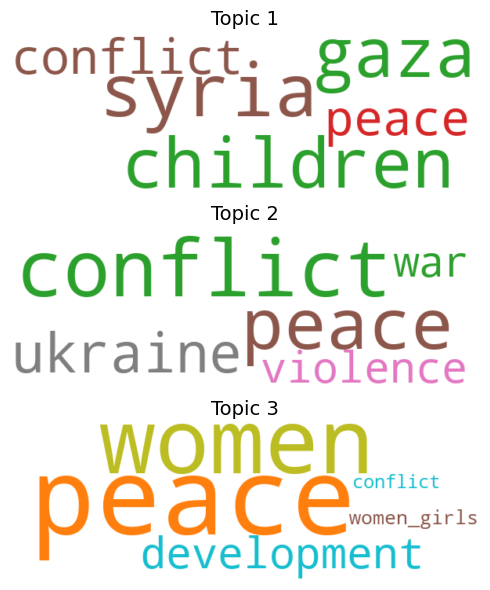

In [53]:
# Topic identification with bigrams
# Text preprocessing function
def preprocess(text):
    text = text.lower()
    text = re.sub(r'[^a-z\s]', '', text)
    tokens = text.split()
    tokens = [token for token in tokens if token not in all_stopwords and len(token) > 2]
    return tokens

# Tokenize texts
tokenized_texts = [preprocess(doc) for doc in texts]

# Build bigrams
bigram_model = Phrases(tokenized_texts, min_count=5, threshold=10)
bigram_phraser = Phraser(bigram_model)
texts_with_bigrams = [bigram_phraser[doc] for doc in tokenized_texts]

# Create dictionary and corpus for LDA
dictionary = corpora.Dictionary(texts_with_bigrams)
dictionary.filter_extremes(no_below=5, no_above=0.75)
corpus = [dictionary.doc2bow(text) for text in texts_with_bigrams]

# Train LDA model with 3 topics
num_topics = 3
lda_model = LdaModel(
    corpus=corpus,
    id2word=dictionary,
    num_topics=num_topics,
    random_state=42,
    passes=10,
    alpha='auto',
    per_word_topics=True
)

# Define figure size in inches for a roughly square layout
fig_width = 6
fig_height = 6

# Each word cloud will have height = fig_height / num_topics
wc_width = int(fig_width * 100)   # 100 dpi
wc_height = int((fig_height / num_topics) * 100)

plt.figure(figsize=(fig_width, fig_height))

for topic_id in range(num_topics):
    plt.subplot(num_topics, 1, topic_id + 1)
    words_probs = dict(lda_model.show_topic(topic_id, topn=5))
    wc = WordCloud(
        width=wc_width,
        height=wc_height,
        background_color='white',
        colormap='tab10',
        prefer_horizontal=0.9,
        min_font_size=15,
    ).generate_from_frequencies(words_probs)
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"Topic {topic_id + 1}", fontsize=14)

plt.tight_layout()
plt.show()

In [54]:
# Export Topics Words and Weights to Excel for PowerBI
topic_words = []
num_words = 5  # Adjust based on your needs

for topic_id in range(num_topics):
    words_probs = lda_model.show_topic(topic_id, topn=num_words)
    for word, prob in words_probs:
        topic_words.append({"Topic": topic_id + 1, "Word": word, "Probability": prob})

# Convert to DataFrame
wc = pd.DataFrame(topic_words)

sheet_name = "Topic_WordCloud"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    wc.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to Topic_WordCloud in uae_mission_statements.xlsx


Identifying Themes Via Keyword Frequency

In [55]:
X = vectorizer.fit_transform(texts)

# Convert to readable DataFrame
X_array = X.toarray()
vocab = vectorizer.get_feature_names_out()
bow_df = pd.DataFrame(X_array, columns=vocab)

# View output
print("Bag of Words Matrix:\n", bow_df.head())

Bag of Words Matrix:
    000  10  100  11  12  13  130  1325  1373  14  ...  yousuf  youth  \
0    0   0    0   0   0   0    0     0     0   0  ...       0      0   
1    0   0    0   0   0   0    0     0     0   0  ...       0      0   
2    0   0    0   0   0   0    0     0     0   0  ...       0      1   
3    0   0    0   0   0   0    0     0     0   0  ...       0      0   
4    0   0    0   0   0   0    0     0     0   0  ...       0      0   

   yugoslavia  zaporizhzhia  zayed  zelenska  zelenskyy  zero  zone  zones  
0           0             0      0         0          0     0     0      0  
1           0             0      0         0          0     0     0      0  
2           0             0      0         0          0     0     0      0  
3           0             0      0         0          0     0     0      0  
4           0             0      0         0          0     0     0      0  

[5 rows x 4036 columns]


In [56]:
# Sum each word's count across all rows
word_counts = bow_df.sum(axis=0)

# Sort words by frequency (descending)
top_words = word_counts.sort_values(ascending=False)

print("Top words:")
print(top_words.head(20))

Top words:
peace             1446
women             1085
conflict           925
like               849
general            608
representative     598
climate            588
delivered          577
states             544
stability          529
importance         524
violence           519
law                513
secretary          507
permanent          486
countries          477
critical           458
war                453
madam              439
challenges         439
dtype: int64


In [57]:
# Determine the most important words using TF-IDF
# Create a TF-IDF Vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words=all_stopwords)
tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

# Convert to DataFrame
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())

# To get overall importance of each word across the corpus, sum TF-IDF scores across all documents
word_importance = tfidf_df.sum(axis=0).sort_values(ascending=False)

print("Top Themes by TF-IDF:")
print(word_importance.head(10))

Top Themes by TF-IDF:
peace       23.783952
women       22.599388
conflict    20.001564
thank       18.796602
ukraine     16.253375
climate     15.716325
like        14.260265
madam       13.868463
syrian      13.489071
sudan       13.312526
dtype: float64


AI Tagging

In [2]:
excel_path = "uae_mission_statements.xlsx"

In [3]:
tagged = pd.read_excel(excel_path, sheet_name="raw")

tagged.head()

,title,url,date,content,theme_1,theme_2
0,UAE Statement At the UN Security Council Brief...,https://uaeun.org/statement/uaesc-sudan-27june...,2025-06-27,"Delivered By: HE Mohamed Abushahab, Ambassador...",Humanitarian Aid,Conflict Resolution and Peacebuilding
1,UAE Statement at the UN Security Council Open ...,https://uaeun.org/statement/uaesc-caac-25june-25/,2025-06-25,"Delivered By: HE Mohamed Abushahab, Ambassador...",Children's Rights,Conflict Resolution and Peacebuilding
2,UAE Statement At the Security Council Open Deb...,https://uaeun.org/statement/uaeunsc-puc-19june...,2025-06-20,"Delivered By: HE Mohamed Abushahab, Ambassador...",Conflict Resolution and Peacebuilding,Human Rights
3,UAE Intervention at the Event to commemorate t...,https://uaeun.org/statement/uaeun-crsv-19june-25/,2025-06-19,"Delivered by: Ms. Myan Tantawy, Political Coor...",Gender Equality,Children's Rights
4,UAE Statement at the Opening Segment of the An...,https://uaeun.org/statement/uaeun-unwomen-17ju...,2025-06-18,"Delivered By: HE Mohamed Abushahab, Ambassador...",Humanitarian Aid,Gender Equality


In [4]:
tagged = tagged.melt(
    id_vars = [col for col in tagged.columns if col not in ['theme_1', 'theme_2']],
    value_vars = ['theme_1', 'theme_2'],
    var_name = 'theme_source',
    value_name = 'theme'
)

tagged = tagged.drop(columns=['theme_source'])

tagged['date'] = pd.to_datetime(tagged['date'], errors='coerce')
tagged['year'] = tagged['date'].dt.year

tagged.head()

,title,url,date,content,theme,year
0,UAE Statement At the UN Security Council Brief...,https://uaeun.org/statement/uaesc-sudan-27june...,2025-06-27,"Delivered By: HE Mohamed Abushahab, Ambassador...",Humanitarian Aid,2025
1,UAE Statement at the UN Security Council Open ...,https://uaeun.org/statement/uaesc-caac-25june-25/,2025-06-25,"Delivered By: HE Mohamed Abushahab, Ambassador...",Children's Rights,2025
2,UAE Statement At the Security Council Open Deb...,https://uaeun.org/statement/uaeunsc-puc-19june...,2025-06-20,"Delivered By: HE Mohamed Abushahab, Ambassador...",Conflict Resolution and Peacebuilding,2025
3,UAE Intervention at the Event to commemorate t...,https://uaeun.org/statement/uaeun-crsv-19june-25/,2025-06-19,"Delivered by: Ms. Myan Tantawy, Political Coor...",Gender Equality,2025
4,UAE Statement at the Opening Segment of the An...,https://uaeun.org/statement/uaeun-unwomen-17ju...,2025-06-18,"Delivered By: HE Mohamed Abushahab, Ambassador...",Humanitarian Aid,2025


In [5]:
sheet_name = "tagging"

with pd.ExcelWriter(excel_path, engine='openpyxl', mode='a', if_sheet_exists="replace") as writer:
    tagged.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"Data successfully saved to {sheet_name} in {excel_path}")

Data successfully saved to tagging in uae_mission_statements.xlsx
